In [1]:
import kaggle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")
submission_df = pd.read_csv("certificatbigdata/sample_submission.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
train_df

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,a,1,0
1,128,2013-01-01,0,0,0,a,1,0
2,420,2013-01-01,0,0,0,a,1,0
3,225,2013-01-01,0,0,0,a,1,0
4,144,2013-01-01,0,0,0,a,1,0
...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343
813763,796,2015-07-31,769,1,1,0,1,8913
813764,230,2015-07-31,1091,1,1,0,1,10988
813765,387,2015-07-31,1402,1,1,0,1,14533


In [4]:
store_df

,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN
...,...,...,...,...
1110,1111,a,a,"Jan,Apr,Jul,Oct"
1111,1112,c,c,NaN
1112,1113,a,c,NaN
1113,1114,a,c,NaN


# DATA CLEANING

In [5]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [6]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [7]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [8]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [9]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [10]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [11]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [12]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [13]:
# Volume de vente est toujours positif
train_df['y'].min()

0

In [14]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [15]:
test_df['y'].min()

0

In [16]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

train_df = train_df.drop(columns=['open'])

In [17]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [18]:
import seaborn as sns

<AxesSubplot:>

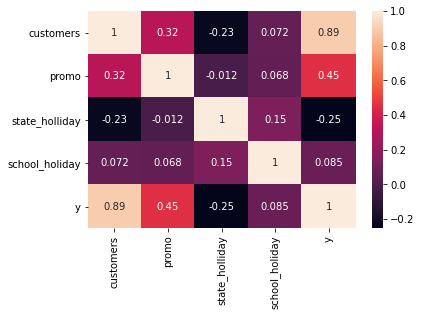

In [19]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

array([[<AxesSubplot:xlabel='customers', ylabel='customers'>,
        <AxesSubplot:xlabel='promo', ylabel='customers'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='customers'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='customers'>,
        <AxesSubplot:xlabel='y', ylabel='customers'>],
       [<AxesSubplot:xlabel='customers', ylabel='promo'>,
        <AxesSubplot:xlabel='promo', ylabel='promo'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='promo'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='promo'>,
        <AxesSubplot:xlabel='y', ylabel='promo'>],
       [<AxesSubplot:xlabel='customers', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='promo', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='y', ylabel='state_holliday'>],
       [<AxesSubplot:xlabel='customers', ylabel='school_holiday'>,
 

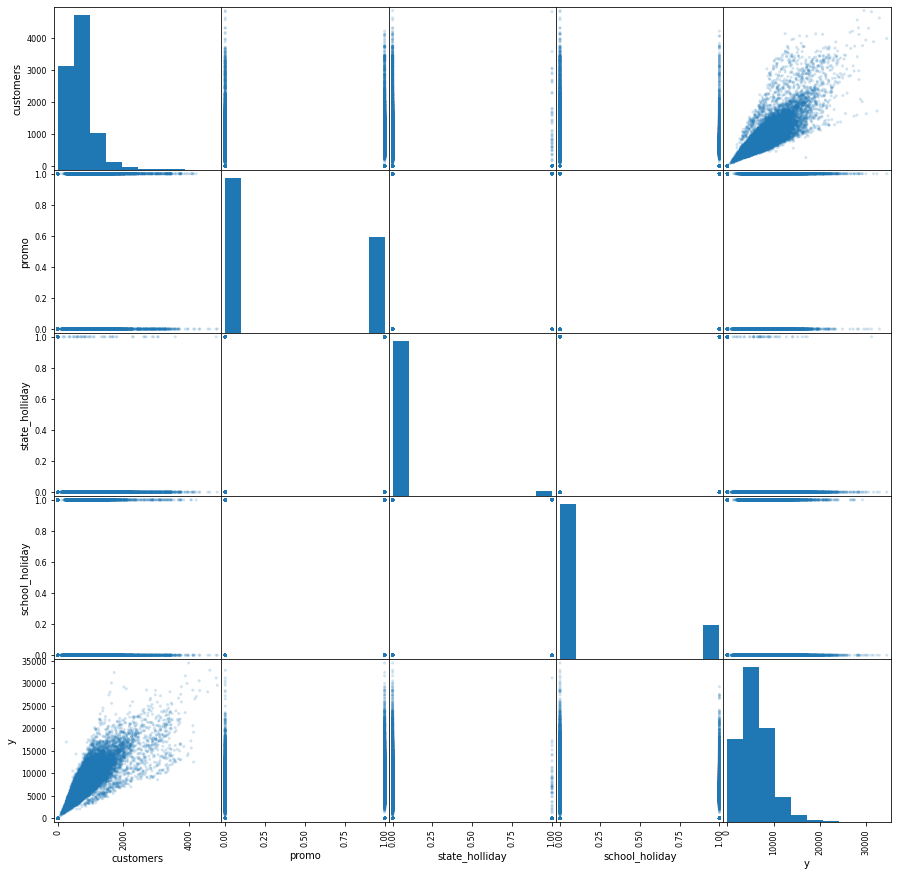

In [20]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

#Feature Eng

In [21]:
display(train_df.head())
display(store_df.head())

,id,date,customers,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,1,1,0
1,128,2013-01-01,0,0,1,1,0
2,420,2013-01-01,0,0,1,1,0
3,225,2013-01-01,0,0,1,1,0
4,144,2013-01-01,0,0,1,1,0


,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN


In [22]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [23]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [24]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

### One hot encoding

In [25]:
# Merger les jeux de données train_df et store_df selon l'id en donnant des valeurs binaires pour chaque type de magasin...

train_df_merged = train_df
for col in ['store_type', 'assortment', 'promo_interval']:
    df1 = pd.get_dummies(store_df[col], prefix=col[:5])
    df1.index.names = ['id']
    df1.index += 1
    train_df_merged = pd.merge(train_df_merged,df1, how ='inner',on='id')

train_df_merged

,id,date,customers,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,store_d,assor_a,assor_b,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec"
0,1042,2013-01-01,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0
1,1042,2013-01-02,548,0,0,1,3628,1,0,0,0,1,0,0,1,0,0
2,1042,2013-01-04,528,0,0,1,3627,1,0,0,0,1,0,0,1,0,0
3,1042,2013-01-05,425,0,0,0,2562,1,0,0,0,1,0,0,1,0,0
4,1042,2013-01-06,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,35,2015-07-27,828,1,0,1,13740,0,0,0,1,0,0,1,0,1,0
813763,35,2015-07-28,711,1,0,1,10877,0,0,0,1,0,0,1,0,1,0
813764,35,2015-07-29,662,1,0,1,10634,0,0,0,1,0,0,1,0,1,0
813765,35,2015-07-30,727,1,0,1,11088,0,0,0,1,0,0,1,0,1,0


In [26]:
#Supprimer la colonne Date

train_df_new = train_df_merged.drop(columns=['date'])

In [27]:
# Vérifier si train_df_new ne contient au final que des valeurs numériques

train_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                        True
customers                 True
promo                     True
state_holliday            True
school_holiday            True
y                         True
store_a                   True
store_b                   True
store_c                   True
store_d                   True
assor_a                   True
assor_b                   True
assor_c                   True
promo_Feb,May,Aug,Nov     True
promo_Jan,Apr,Jul,Oct     True
promo_Mar,Jun,Sept,Dec    True
dtype: bool

In [28]:
X_train = train_df_new.drop(columns=['id','y'])
y_train = train_df_new['y']
#Pour l'instant on entraine notre modèle sans l'input Date!


# Train Models Pipeline

In [29]:
Models = dict()

In [30]:
def train_model_grid_search(model_name, model, grid, train_data=(X_train,y_train), 
                            eval_metric='r2', save_dict=Models, verbose=1):
    """
    model_name : Name of the model
    model : sklearn model
    grid : Hyper parameters search grid
    train_data : (train inputs, train outputs)
    eval_metric : evaluation metric in the grid search
    ------------------
    Trains model on training data using a grid search and cross validation then saves trained model in save_dict
    """
    model_cv = GridSearchCV(model, grid, scoring=eval_metric, cv=5)
    model_cv.fit(X_train, y_train)
    train_preds = model_cv.predict(X_train)
    save_dict[model_name] = {'model':model_cv,
                             'scores':{'train': model_cv.best_score_,
                                       #r2_score(y_train, train_preds),
                                       }}
    if verbose ==1:
        print(f" -  {model_name} best hyperparameters : {model_cv.best_params_}",'\n\n')
        print(f" -  {model_name} regression results on the train set:")
        print(model_cv.best_score_)

## Regression

In [31]:
train_model_grid_search(model_name = 'Linear Regression',
                        model = LinearRegression(),
                        grid = {'fit_intercept':[True,False], 
                                'copy_X':[True, False],
                                'normalize':[True,False]})

 -  Linear Regression best hyperparameters : {'copy_X': True, 'fit_intercept': False, 'normalize': True} 


 -  Linear Regression regression results on the train set:
0.8890042720735781


## Decision trees


In [32]:
#train_model_grid_search(model_name = 'Decision Tree',
#                        model = DecisionTreeClassifier(),
#                        grid = {'max_depth':list(range(2,10)),
#                                })

## Random Forest

In [ ]:
#train_model_grid_search(model_name = 'Random Forest',
#                        model = RandomForestClassifier(min_samples_split=2, random_state = 42),
#                        grid = {'max_depth': range(10,200,50),
#                                'min_samples_leaf':range(2,10,3),
#                                'n_estimators': [100, 200, 500]})

C:\Users\omabe\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
